In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# lecture du jeu de données
df = pd.read_csv("loan_default_data.csv")
df.head(5)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [4]:
df.shape

(255347, 18)

In [9]:
df.dtypes

LoanID             object
Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object

In [10]:
df.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


In [ ]:
# Valeur Manquante
df.isna().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [16]:
# Comptage des classes
print(df["Default"].value_counts())

# Pourcentage de chaque classe
print(df["Default"].value_counts(normalize=True) * 100)

Default
0    225694
1     29653
Name: count, dtype: int64
Default
0    88.387175
1    11.612825
Name: proportion, dtype: float64


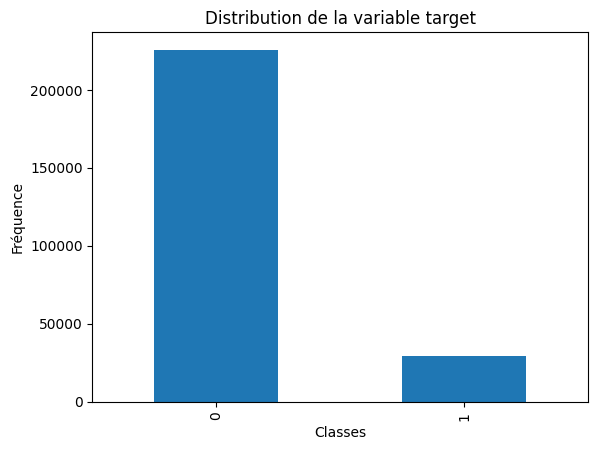

In [14]:
# Vérifier si le dataset est équilibré
# Connaitre la répartition des données en fonction de la target

# Si target est catégorielle
df["Default"].value_counts().plot(kind="bar")
plt.title("Distribution de la variable target")
plt.xlabel("Classes")
plt.ylabel("Fréquence")
plt.show()

Le jeux de données est déséquilibré, car il y'a plus de 0 que de 1. La classe 1 est très minoritaire para rapport à la classe 0